# GEOS 505: Problem Set 3

### Background:

As part of your thesis, you are using a physics-based model to predict how the timing and amount of snow water storage in the Boise River Basin will change under alternative future scenarios of climate. You have your model up and running and presented preliminary results for the first time at a recent committee meeting. One of your committee members works with the Idaho NRCS snow survey and points out that your results would be more impactful if you could present them in the context of historical observations of snow water equivalent (SWE). In particular, your committee wants you to plot your simulations on top of historical SNOTEL climatology, presented as follows: 

<img src="../img/trinity_mtn-id-wteq-por.png" alt="Trinity Mtn. SNOTEL" width="1000" style="display: block; margin: 0 auto"/>

This figure, which can be generated on the NRCS website for any SNOTEL site and many water supply basins. This particular image is the 30 year "normals" for the 1991-2020 timeframe at Trinity Mountain SNOTEL site in the Upper Boise. The plot contains a water-year oriented plot of the following items:

- The median SWE vs time,
- The median maximum annual SWE on April 1, 
- The minimum SWE vs time,
- The maximum SWE vs time, and
- Filled in ranges for SWE quintiles (bottom 20%, 20-40%, 40-60%, 60-80%, and top 20%) vs time.

### Problem: 

Your hypothetical task for your thesis and the task for this problem set is to reproduce the above figure in a way that would allow you to analyze and plot historical data at a variety of SNOTEL sites, and in a way that would allow you to plot the corresponding version of this plot with simulated data for a future climate. As such, the expected outcome of this notebook is code that produces an image that looks similar to the above. You may certainly use an alternative color scheme, but make sure that the elements of the plot are labeled.

The outline of the steps is provided below, along with some helpful suggestions of `numpy` and `matplotlib` functions that you will likely need.

### 1. Imports and Definitions

In [2]:
from datetime import datetime
from dataretrieval import nwis
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

startDate = '1985-10-01'
endDate = '2025-09-30'

startDate_dt = datetime.strptime(startDate, '%Y-%m-%d')
endDate_dt = datetime.strptime(endDate, '%Y-%m-%d')

# Metloom Variables
snotel_stn = '830:ID:SNTL' # Trinity Mountain Snotel Station
snotel_pnt = SnotelPointData(station_id=snotel_stn, name='TrinityMtn')

variables = [snotel_pnt.ALLOWED_VARIABLES.SWE]

### 2. Load the Data and Verify

In [3]:
df_snotel = snotel_pnt.get_daily_data(startDate_dt, endDate_dt, variables)
df_snotel


,,geometry,SWE,SWE_units,datasource
datetime,site,,,,
1985-10-01 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-02 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-03 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-04 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-05 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
...,...,...,...,...,...
2025-09-26 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-27 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-28 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS


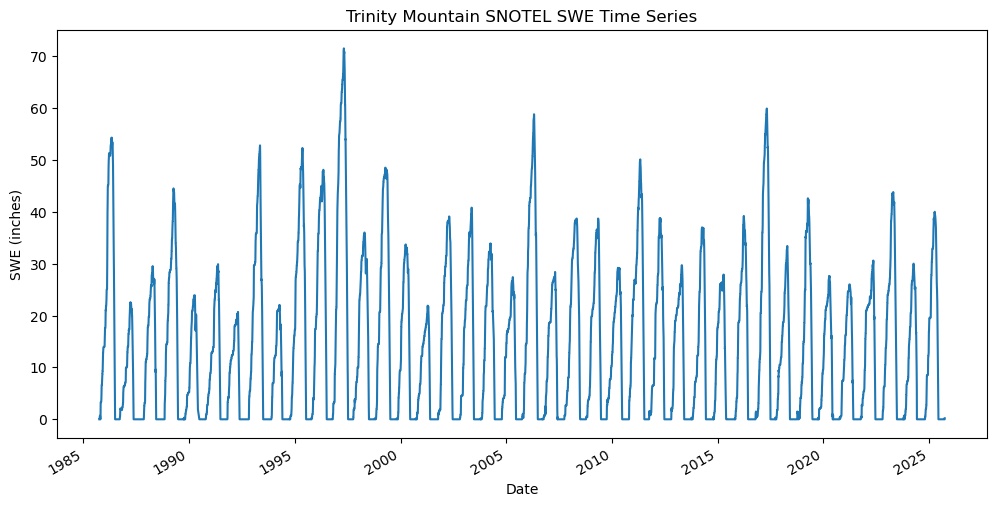

In [4]:
df_snotel.reset_index(level='site', inplace=True)
df_snotel['SWE'].plot(title='Trinity Mountain SNOTEL SWE Time Series', ylabel='SWE (inches)', xlabel='Date', figsize=(12,6))
plt.show()

In [5]:
nYears = (endDate_dt.year - startDate_dt.year) + 1

### 3. Prep Data and Preallocate Storage

In [6]:
swe_time_series = np.full((nYears, 365), np.nan) #changing this to NaN because there are a few missing values in the df
swe_time_series

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(41, 365))

Just some notes before I start bringing all of the data into a useable dataframe.

Mapping df_snotel to the swe_time_series

I am trying to create the same structure below so it can be dropped into the swe time series array... I am struggling to wrap my head around the preallocated storage for this application. There is a groupby argument that is on the tip of my tongue for this, and for some reason this data frame management is confusing relative to R for me right now!

I want to have an argument that checks for %m %d = 02-29 and exclude september 30th when that is true - resolved with the != 366

I don't really care about anything besides water year datetime and SWE...

In [7]:
wy_date = df_snotel.reset_index()
wy_date['date'] = pd.to_datetime(wy_date['datetime']) # indexed datetime was a series object (because I used reset_index, I wanted to experiment with this), this changes it back to a datetime
wy_date['wy'] = wy_date['date'].dt.year + (wy_date['date'].dt.month >= 10).astype(int)
wy_date['doy'] = wy_date['date'].dt.dayofyear #day of year, so that I can wipe any september 30 that is day 366
wy_date['wy_doy'] = np.where(wy_date['doy'] >= 274, wy_date['doy'] - 273, wy_date['doy'] + 92)
#since I used dayofyear, I dont have to worry about when a given row is missing, since I have observed the day of year from the datetime variable
#This means that I can run this calc and not worry about mis-attributing a wy_doy value when a row gets skipped.
wy_date = wy_date[wy_date['wy_doy'] != 366] #get those leap days out of here!
wy_date

##wy_date has 14559 with leap years, and 14549 without leap years - successful subsetting but there are a few missing data points...
##This does matter because we want to have 365 rows of 41 columns... 14965 rows... need to use NAs otherwise we track false zeros

#this was my initial attempt... I was trying to create 14549 columns! ChatGPT had to help me with this .groupby, took an embarrasing amount of time to think about how to use groupby here...
#swe_time_series = wy_date.pivot(index = 'wy_doy', columns = 'wy', values = "SWE")

wy_date_grouped = wy_date.groupby(['wy', 'wy_doy'])['SWE'].first().reset_index()
swe_time_series = wy_date_grouped.pivot(index='wy_doy', columns='wy', values='SWE')


swe_time_series


wy,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
wy_doy,,,,,,,,,,,,,,,,,,,,,
1,0.0,2.1,0.0,NaN,0.1,0.0,0.0,NaN,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I am seeing some cheeky NaNs in there! I wonder why the first day of the water year could be missing...
Had to vibe code the groupby but I feel like this was a fairly concise solution to getting the wy_doy variable right

Could this be faster if I didnt reset the index??? I think I am more comfortable with a raw index instead of a variable index because of R dataframe habits...

In [8]:
print(swe_time_series.shape)
print(swe_time_series.columns)

#sanity check! all years are there :)

(365, 40)
Index([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025],
      dtype='int64', name='wy')


### 4. Analyze Data

In [9]:
#I have seen some of the NaNs... need to use .nanmin, .nanmax, .nanmedian to ignore missing data
swe_min = np.nanmin(swe_time_series, axis = 1) 
swe_max = np.nanmax(swe_time_series, axis = 1)
swe_med = np.nanmedian(swe_time_series, axis = 1)
quintiles = np.nanpercentile(swe_time_series, [0,20,40,60,80,100], axis = 1)


In [10]:
print(type(swe_time_series))


<class 'pandas.core.frame.DataFrame'>


In [11]:
#now for apri 1 (I wish I could do April 4th, its a great day of the year)
#running into an issue where I cannot use an index to reference a pandas data frame. 
#because I am using an integer index, documentation suggests using .iloc
#https://pandas.pydata.org/docs/user_guide/indexing.html
Apr_index = 183
apr_swe = swe_time_series.iloc[Apr_index, :] #had to learn how this syntax operated - ":" selects all columns across the supplied index
med_apr_swe = np.nanmedian(apr_swe)

In [12]:
print(quintiles)
print(quintiles.shape)

print(swe_min.shape)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [2.1 2.  2.  ... 1.8 1.9 2. ]]
(6, 365)
(365,)


### 5. Create Plot

What I need:
- The median SWE vs time,
- The median maximum annual SWE on April 1, 
- The minimum SWE vs time,
- The maximum SWE vs time, and
- Filled in ranges for SWE quintiles (bottom 20%, 20-40%, 40-60%, 60-80%, and top 20%) vs time.

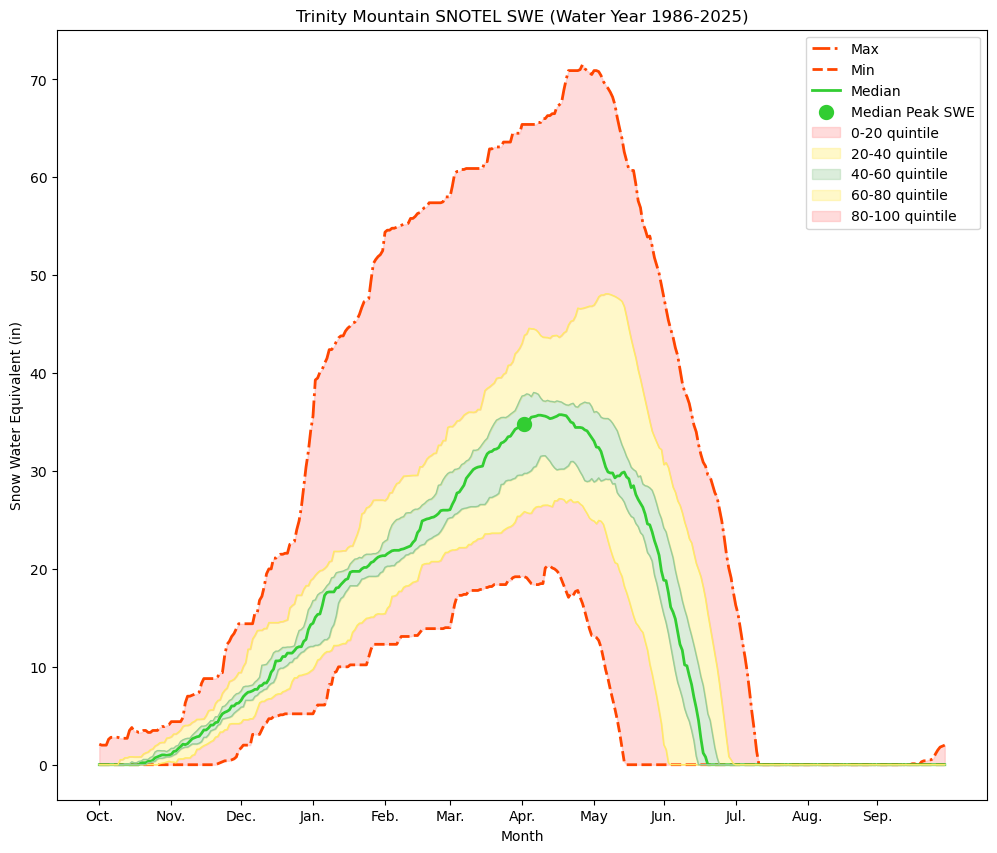

In [15]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(swe_max, label='Max', color='#FF4500', linestyle = '-.', linewidth=2)
ax.plot(swe_min, label='Min', color='#FF4500', linestyle = '--', linewidth=2)
ax.plot(swe_med, label='Median', color='#32CD32', linewidth=2)
ax.scatter(183, med_apr_swe, color='#32CD32', linewidth=5, label='Median Peak SWE', zorder=5) #183 is april 1

ax.fill_between(np.arange(365), swe_min, quintiles[1], color='#FF9999', alpha=0.35, label='0-20 quintile')

ax.fill_between(np.arange(365), quintiles[1], quintiles[2], color='#FFEB66', alpha=0.35, label='20-40 quintile')

ax.fill_between(np.arange(365), quintiles[2], quintiles[3], color='#99CC99', alpha=0.35, label='40-60 quintile') 
ax.fill_between(np.arange(365), quintiles[3], quintiles[4], color='#FFEB66', alpha=0.35, label='60-80 quintile')
ax.fill_between(np.arange(365), quintiles[4], swe_max, color='#FF9999', alpha=0.35, label='80-100 quintile')

ax.plot(quintiles[1], color='#FFEB66', linewidth=1, alpha= 1)
ax.plot(quintiles[2], color='#99CC99', linewidth=1, alpha= 1)
ax.plot(quintiles[3], color = '#99CC99', linewidth=1, alpha= 1)
ax.plot(quintiles[4], color = '#FFEB66', linewidth = 1, alpha = 1)

month_labels=['Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.']
ax.set_xticks([0, 31, 61, 92, 123, 151, 182, 213, 243, 274, 305, 335]) #had to vibe this too, the way my plot was interpreting the xticks graphed it in mid march instead of april
ax.set_xticklabels(month_labels)

ax.set_ylabel('Snow Water Equivalent (in)')
ax.set_xlabel('Month')
ax.set_title('Trinity Mountain SNOTEL SWE (Water Year 1986-2025)')
ax.legend(loc='upper right')

plt.show()


sorry to color blind folks, but I think the extremes look better in red!

for identifying future things to focus on, I definitely need to focus on handling dataframes that are indexed by variables, break some bad habits.
I also need to work on thinking about ways to build data frames - especially big ones - since I will be assimilating a lot of data from a lot of different places. 
I need to practice with groupby more, and figuring out how to move data from one space into another more cohesively. 